# Differential Equation Solving with Python 2

Notebook to implement the 4th order Runge-Kutta scheme to solve differential equations for Abertay University undergrad course MAT301 (JT, 2022).


---


**Remember:** The aim of MAT301 is for you to understand and implement the mathematics of each iterative solution you have been shown. The MAT301 exam will test your ability to demonstrate the mathematical steps, on pen and paper. 

These codes are for additional context **once you are able to carry out the mathematical steps**: our ultimate goal is that you are able to create numerical schemes to solve problems for yourselves in future. These codes should **NOT** be used in the exam or replace your pen and paper approach to tutorial problems. However, I do encourage you to use these codes to verify your tutorial solutions after you have already solved the problems mathematically.



---


Some images and more formal description of the mathematics based upon [Python Programming And Numerical Methods: A Guide For Engineers And Scientists](https://pythonnumericalmethods.berkeley.edu/notebooks/Index.html) which is a really useful resource for many different applications of Python to numerical methods. 





# 4th Order Runge Kutta Algorithm
As seen in lectures, a highly common approach to solve differential equations is to use the RK4 algorithm. This is one of a family of Runge-Kutta (RK) algorithms, which are based on the same mathematical ideas. RK4 is an industry standard, representing a good trade-off between accuracy and complexity.

We apply Runge-Kutta algorithms to differential equations which take the same form, namely:
\begin{equation} y^{'} = f(x,y). \end{equation}
The algorithm uses the values of the independent variable $x$ and dependent variable $y$ at specific values ($x_n$ and $y_n$) in order to approximate the next value of $y$ using:
\begin{equation} y_{n+1}=y_n+hk,\end{equation}
for $n=0,...,N-1$. The form of the coeffient $k$ varies depending on the particular RK scheme used; for RK4 we note: 
\begin{equation} k=\frac{1}{6}\left[ k_1+2k_2+2k_3+k_4\right],\end{equation} and individual components $k_1\rightarrow k_4$ are determined by evaluating the function at different locations according to:
\begin{eqnarray}
k_1&=&f\left(x_n,y_n\right), \\
k_2&=&f\left(x_n+\frac{1}{2}h,y_n+\frac{1}{2}hk_1\right), \\
k_3&=&f\left(x_n+\frac{1}{2}h, y_n+\frac{1}{2}hk_2\right), \\
k_4&=&f\left(x_n+h, y_n+hk_3\right).
\end{eqnarray}
In all of these examples $h$ is the stepsize with which we step along in $x$.

We have already seen in the lectures how the method can be applied to different differential equations. However, the real power of this method lies in its iterative behaviour; we can use computers to crank up the number of steps of calculation (or decrease the step size) to calculate an (approximate) solution over a large range of $x$.



To illustrate how this method can be implemented numerically, we will apply it to three initial value problems. These happen to be models of population growth over time, but could in reality be for any type of ordinary differential equation (ODE, or indeed for a system of several coupled ODEs). I have selected these equations because they are broadly related, but gradually increase in complexity. The equations which we will investigate are the following:
### 1. Linear 
Our first ODE will be linear:
\begin{equation} y^{'}=0.1y, \ \ (2000 \leq t \leq 2020), \end{equation}
with the initial condition,
\begin{equation}y(2000)=6.\end{equation}

### 2. Non-Linear Population Equation 
Our second ODE will contain more terms and a higher power in $y$:
\begin{equation} y^{'}=0.2y-0.01y^2, \ \ (2000 \leq t \leq 2020), \end{equation}
with the initial condition,
\begin{equation}y(2000)=6.\end{equation}

### 3. Non-Linear Population Equation with an oscillation 
Our final ODE will include an extra complication of an oscillatory part added to the previous ODE: 
\begin{equation} y^{'}=0.2y-0.01y^2+\sin(2\pi t), \ \ (2000 \leq t \leq 2020), \end{equation}
with the initial condition,
\begin{equation}y(2000)=6.\end{equation}

We will tackle each of these equations in turn, applying the RK4 algorithm to each problem and comparing results with any known analytical solutions of the problem.

#### Setting up Libraries

As always, we'll make use of some clever python tools for plotting and maths, so our first step is to load in the libraries that store these tools:

In [1]:
## Libraries
%matplotlib inline
import numpy as np
import math 
import pandas as pd #good library for tables
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

## Discrete Interval
The independent variable, which for these equations is time, $t$, has a particular range $a\leq t \leq b $. We divide this interval into $N$ points separated by a constant stepsize using the equation stated in our lectures:
\begin{equation} h=\frac{b-a}{N}.\end{equation}


Here, the interval is $2000\leq t \leq 2020,$ 
\begin{equation} h=\frac{2020-2000}{200}=0.1.\end{equation}
This gives the 201 discrete points:
\begin{equation} t_0=2000, \ t_1=2000.1, \ ... t_{200}=2020, \end{equation}
which we can generalise to
\begin{equation} t_n=2000+0.1n, \ \ \ n=0,1,...,200.\end{equation}

Let's go ahead and set this range of $t$ values as a list in Python:

In [2]:
N = 200
t_end = 2020.0
t_start = 2000.0
h = ((t_end - t_start) / N)
t = np.arange(t_start, t_end + h / 2, h)

Normally, I'd print these, but for this massive range of times I think it would be better to visualise these with a plot: 

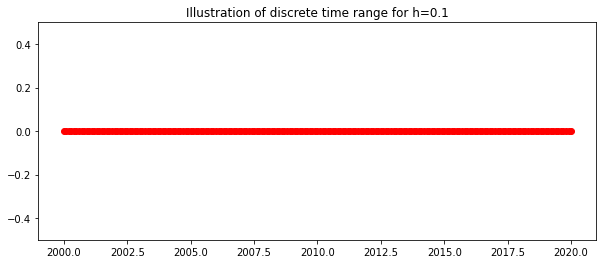

In [3]:
fig = plt.figure(figsize=(10,4))
plt.plot(t,0*t,'o:',color='red')
plt.title('Illustration of discrete time range for h=%s'%(h))
plt.ylim(-0.5,0.5)
plt.show()

So it looks like our time range works, starting and ending at the correct values and with the correct step size.

# 1. Linear Population Equation

### Tailoring our 4th Order Runge Kutta scheme
To write the specific 4th Order Runge Kutta method for the linear population equation we need 
\begin{equation}f(x,y)=0.1y.\end{equation}
(where I've switched back to calling the dependent variable 'x' rather than time 't' for consistency with lecture notes).

So lets go ahead and create a function which returns the right hand side of this equation for a given value of $x$ and $y$:

In [4]:
def l_fun(x,y):
    ftw = 0.1 * y
    return ftw

We now need to evaluate each of the coefficients, beginning with $k_1$. In the lectures we manually calculated formulae to describe each coefficient and evaluate these in a table before combining.

The first coefficient, $k_1$, would look like:
\begin{equation}k_1=f\left(x_n,y_n\right)=0.1 y_n.\end{equation}

Subsequent coefficients are more complicated to evaluate mathematically, e.g. $k_2$:
\begin{eqnarray}
k_2&=&f\left(x_n+\frac{h}{2},y_n+\frac{h}{2}k_1\right)=0.1\left(y_n+0.05k_1\right) \\
&=&0.1\left(y_n+0.05(0.1y_n)\right)=0.1y_n(1+0.005) \\
&=&0.1y_n(1.005)=0.1005y_n.
\end{eqnarray}
This is a lot of mathematical effort to then plug into our calculators!

The beauty of this method relies on making the computer to do the hard work for us! Now that we've defined a function to spit out values of $f(x,y)$, we can also evaluate *shifted values* of $x$ and $y$ as input into that function to evaluate $k_1-k_4$, and hence the next iteration of the solution, $y_{n+1}$:

In [5]:
yn = np.zeros(N + 1)
yn[0] = 6.0
## 4th Order Runge Kutta
for n in range (0,N):
    k1 = l_fun(t[n], yn[n])
    k2 = l_fun(t[n] + 0.5 * h, yn[n] + 0.5 * h * k1)
    k3 = l_fun(t[n] + 0.5 * h, yn[n] + 0.5 * h * k2)
    k4 = l_fun(t[n] + h, yn[n] + h * k3)
    yn[n + 1] =yn[n] + h / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

### Exact Solution 
From MAT201 mathematics, we should also know that this equation can be separated and integrated, using the initial conditions to evaluate any constants of integration.

This simple separable first order ODE 
\begin{equation} y^{'}=0.1y, \ \ (2000 \leq t \leq 2020), \end{equation}
with the initial condition,
\begin{equation} y(2000)=6.\end{equation}
has a simple exact (analytic) solution
\begin{equation} y(t)=6e^{0.1(t-2000)}, \end{equation}
which you should be able to derive analytically yourself - see MAT201 notes for a refresher on this!


### Plotting Results

We'll now plot the approximate Runge-Kutta solution against the exact solution over time, to see how they behave:

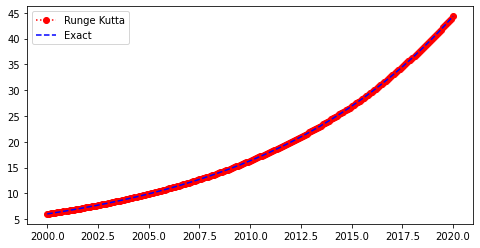

In [6]:
y_true = 6 * np.exp(0.1 * (t - 2000))
fig = plt.figure(figsize=(8,4))
plt.plot(t,yn,'ro:',label='Runge Kutta')
plt.plot(t,y_true,'b--',label='Exact')
plt.legend(loc='best')
plt.show()

As one might expect, because of the fourth order accuracy of the RK4 algorithm, both solutions are incredibly well matched when viewed this way.

Rather than zoom in to any part of the graph, it can be easier to assess how accurate our scheme is using a table.

### Tablulating our results
The table below shows the time, the Runge Kutta numerical approximation, $y$,  the exact solution, $y_{\rm{true}}$, and the exact error $|y_{\rm{true}}(t_n)-y_n|$ for the linear population equation:

In [7]:
d = {'time t_n': t[0:10],    'Runge Kutta (y_n)':yn[0:10],'Exact (y_true)':y_true[0:10],'Exact Error':np.abs(np.round(y_true[0:10]-yn[0:10],10))}
df = pd.DataFrame(data=d)
df

,time t_n,Runge Kutta (y_n),Exact (y_true),Exact Error
0,2000.0,6.000000,6.000000,0.0
1,2000.1,6.060301,6.060301,0.0
2,2000.2,6.121208,6.121208,0.0
3,2000.3,6.182727,6.182727,0.0
4,2000.4,6.244865,6.244865,0.0
5,2000.5,6.307627,6.307627,0.0
6,2000.6,6.371019,6.371019,0.0
7,2000.7,6.435049,6.435049,0.0
8,2000.8,6.499722,6.499722,0.0
9,2000.9,6.565046,6.565046,0.0


You'll hopefully note that the error in the final column is zero. This is because the RK4 algorithm is highly accurate and we've used a very complicated algorithm for a very simple ODE. 

Lets now explore two other Differential Equations where we will slowly crank up the complexity to see if that makes any noticeable difference to our iterative RK4 answers.

## 2. Non-Linear Differential Equation
Our second equation will be a non-linear differential equation (effectively still an ordinary differential equation but with a higher order power of the dependent variable $y$).

Since our first equation was an equation describing population evolution over time, we'll choose another differential equation describing population behaviour:
\begin{equation} y^{'}=0.2y-0.01y^2, \ \ (2000 \leq t \leq 2020), \end{equation}
with the same initial condition as before, namely that
\begin{equation}y(2000)=6.\end{equation}

### Implementing RK4 

To write the specific 4th Order Runge Kutta method we need
\begin{equation}f_2(x,y)=0.2y-0.01y^2.\end{equation}


Again we could, if we choose to, calculate $k_1, k_2, k_3, k_4$ by hand, e.g.
\begin{equation}k_1=f_2(x_n,y_n)=0.2y_n-0.01y_n^2.\end{equation}

However, we can again take advantage of the computer, and define a function to return the right hand side of the population equation, and feed in the correct values of $t$ and $y$.

In [8]:
def nl_fun(x,y):
    ftw = 0.2 * y - 0.01 * y * y
    return ftw

In [9]:
yn2 = np.zeros(N + 1)
yn2[0] = 6.0
## 4th Order Runge Kutta
for n in range (0, N):
    k1 = nl_fun(t[n],yn2[n])
    k2 = nl_fun(t[n] + 0.5 * h , yn2[n] + 0.5 * h * k1)
    k3 = nl_fun(t[n] + 0.5 * h , yn2[n] + 0.5 * h * k2)
    k4 = nl_fun(t[n] + h, yn2[n] + h * k3)
    yn2[n+1] = yn2[n] + h / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

### Results and Graph

While this ODE is more complicated, it also has an analytical solution; by again separating and integrating and making use of the standard integral result that 
\begin{equation}
\int{\frac{\rm{d}x}{x\left(a+bx\right)}}=\frac{1}{a}\ln{\left|\frac{a+bx}{x}\right|}+c,
\end{equation}
we can therefore find:
\begin{equation} y(t)=\left({5e^{\dfrac{-(t+c)}{5}}+0.05}\right)^{-1}, \end{equation}
with a contant of integration \begin{equation}c=-5\ln{\left(\frac{0.14\exp{(400)}}{6}\right)}\end{equation}

The plot below again shows the RK4 numerical approximation, $y_n$ (circles) and the analytical solution to the non-linear population equation:

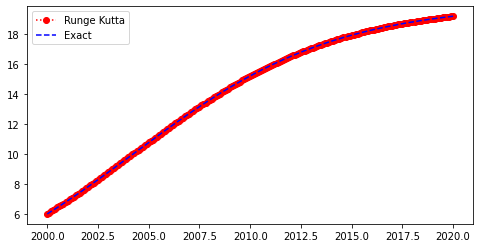

In [10]:
c1 = -5.0 * np.log(0.14 * np.exp(400) / 6.0)
y_nltrue = 0.2 / (np.exp(-0.2 * (t + c1)) + 0.01)
fig2 = plt.figure(figsize=(8,4))
plt.plot(t,yn2,'ro:',label='Runge Kutta')
plt.plot(t,y_nltrue,'b--',label='Exact')
plt.legend(loc='best')
plt.show()

Once more the plots are indistinguishable, again suggesting that our numerical scheme has found an approximate solution which closely matches the true solution. Once more, a table should again highlight exactly how accurate the approximation is.

### Results Table
The table below shows the time and the Runge Kutta numerical approximation, $w$,  for the non-linear population equation:

In [11]:
d = {'time t_n': t[0:10],'Runge Kutta (y_n)':yn2[0:10],'Exact (y_true)':y_nltrue[0:10],
     'Exact Error':np.abs(np.round(y_nltrue[0:10]-yn2[0:10],10))}
df = pd.DataFrame(data=d)
df

,time t_n,Runge Kutta (y_n),Exact (y_true),Exact Error
0,2000.0,6.000000,6.000000,0.000000e+00
1,2000.1,6.084335,6.084335,0.000000e+00
2,2000.2,6.169332,6.169332,0.000000e+00
3,2000.3,6.254983,6.254983,1.000000e-10
4,2000.4,6.341278,6.341278,1.000000e-10
5,2000.5,6.428207,6.428207,1.000000e-10
6,2000.6,6.515759,6.515759,1.000000e-10
7,2000.7,6.603924,6.603924,1.000000e-10
8,2000.8,6.692689,6.692689,1.000000e-10
9,2000.9,6.782043,6.782043,2.000000e-10


The table illustrates that for this equation, a very small (but nevertheless non-zero) error creeps in after a few timesteps, and appears to grow every few steps.

The first few steps in the table are likely to be zero due to rounding: this worksheet displays numbers to a preset number of decimal places.

## 3. Non-Linear Population Equation with an oscillation 
In our final differential equation, lets yet again use a more complex population model and evaluate how well RK4 does. The population model is essentially the previous model with an additional sine term (representing shorter fluctuations in population than the long term behaviour):

\begin{equation} y^{'}=0.2y-0.01y^2+\sin(2\pi t), \ \ (2000 \leq t \leq 2020), \end{equation}
with the initial condition,
\begin{equation}y(2000)=6.\end{equation}

### Implementing RK4
As with the previous cases, lets express the right hand side of the ODE as a function
\begin{equation}f_3(x,y)=0.2y-0.01y^2+\sin(2\pi x),\end{equation}

Once again, we could mathematically calculate expressions for $k_1\rightarrow k_4$. 
This time though, you can see that $f_3(x,y)$ now contains terms that depend on $y$ **and** $t$!

Now that we're more familiar with how to implement RK4 numerically, we'll simply move on to define our function representing $f_3(x,y)$ and let the code evaluate the coefficients:

In [12]:
def nlo_fun(x, y):
    ftw = 0.2 * y - 0.01 * y * y + np.sin(2 * np.math.pi * x)
    return ftw

In [13]:
yn3 = np.zeros(N + 1)
yn3[0] = 6.0
## 4th Order Runge Kutta
for n in range (0,N):
    k1 = nlo_fun(t[n],yn3[n])
    k2 = nlo_fun(t[n] + 0.5 * h, yn3[n] + 0.5 * h * k1)
    k3 = nlo_fun(t[n] + 0.5 * h, yn3[n] + 0.5 * h * k2)
    k4 = nlo_fun(t[n] + h, yn3[n] + h * k3)
    yn3[n + 1] = yn3[n] + h / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

### Results Graph
This final ODE is quite a lot more complicated than the two previous ones (note for example, that it's not separable). We could employ more advanced mathematical techniques to derive an analytical solution, but that isn't the focus of our work here, so for now we'll just focus on the RK4 solution that we obtain from our numerical technique 

The plot below shows the 4th order Runge Kutta numerical approximation, $y$ (circles) for the non-linear population equation:

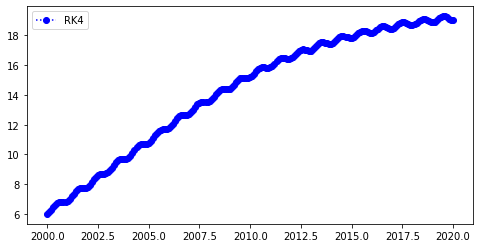

In [14]:
fig3 = plt.figure(figsize=(8,4))
plt.plot(t,yn3,'bo:',label='RK4')
plt.legend(loc='best')
plt.show()

The graph shows the behaviour of the solution; as we might expect the overal population increase that we witnessed in case 2 has been modified by a shorter oscillatory pattern.

This emphasises the power of RK4: we have used it to solve an equation which has **no simply analytical solution**. Given our previous test case, we can be confident of a high degree of accuracy, despite having no solution to compare it too.

### Results Table
The table below shows the time and RK4 solution, $yn3$,  for the non-linear population equation:

In [15]:
d = {'time t_n': t[0:10], 'Runge Kutta':yn3[0:10]}
df = pd.DataFrame(data=d)
df

,time t_n,Runge Kutta
0,2000.0,6.000000
1,2000.1,6.114813
2,2000.2,6.279909
3,2000.3,6.465115
4,2000.4,6.632805
5,2000.5,6.752294
6,2000.6,6.811571
7,2000.7,6.821875
8,2000.8,6.813379
9,2000.9,6.823656


## Python ODE solvers

Python is a clever bit of kit, with entire libraries dedicated to solving numerical problems like these. Some of these libraries even come with built in solvers to carry out the tasks we have just performed. If you feed a particular function, initial/final values, and even explicit grid-size to these solvers, we can obtain automated solutions to our problem:

In [16]:
from scipy.integrate import solve_ivp
sol = solve_ivp(nlo_fun, [t_start, t_end], [6.0], t_eval=t)
sol2 = solve_ivp(nlo_fun, [t_start, t_end], [6.0],  method='DOP853', t_eval=t)

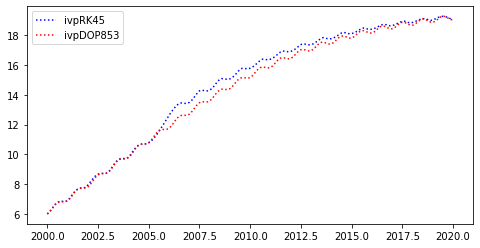

In [18]:
fig3 = plt.figure(figsize=(8,4))
plt.plot(sol.t,sol.y[0],'b:',label='ivpRK45')
plt.plot(sol2.t,sol2.y[0],'r:',label='ivpDOP853')
plt.legend(loc='best')
plt.show()

Note that the native RK45 routine in this package finds a slightly different solution to the 8th order accurate *DOP853* method. If you opt to use intrinsic functions, you need to take care that they are set up correctly, preferably testing them on some simple examples first!

Investigate the documentation of the *solve_ivp* function from the *scipy.integrate* package, to explore this process in detail.

## Further work
Now its over to you:

Try choosing a worked example seen in the lectures, or indeed a tutorial question **once you have worked through the mathematical steps** and see if you can create a new implementation of RK4 to verify the solution!